# MRI Brain Tumor Classification (Colab Notebook)

### Introduction
Brain tumors are abnormal growths of cells within the brain or central nervous system. Early
detection and accurate classification of brain tumors play a crucial role in determining the correct
treatment plan and improving patient outcomes. Magnetic Resonance Imaging (MRI) is one of the
most effective non-invasive imaging techniques for detecting and analyzing brain tumors.



### Dataset Description
We used the Brain Tumor MRI Dataset which contains MRI images categorized into four

classes:
1. Glioma
2. Meningioma
3. No Tumor
4. Pituitary Tumor


Each class contains MRI scans taken from different patients, with variations in orientation, lighting,
and quality.
The dataset was preprocessed and split into:

Training set – For model learning.

Testing set – For final evaluation.



## Preprocessing Techniques
Before training the model, we applied several preprocessing steps to ensure

optimal performance:

Image resizing to 224x224 pixels for compatibility with deep learning models.
Normalization of pixel values to the range [0, 1] .

Data augmentation to improve generalization:

-- Random rotation

-- Horizontal and vertical flips

-- Zooming and shifting

--  Categorical encoding of class labels for multi-class classification.
  Ensuring balanced classes through proper splitting.


### Model Architecture & Training

We used Transfer Learning to leverage the power of pre-trained convolutional neural networks

(CNNs). This approach allows us to use models trained on large datasets like ImageNet and finetune them for our specific task.

Base model: Pre-trained CNN (e.g., EfficientNet, VGG, or similar).

Top layers: Custom dense layers for classification into 4 classes.

Loss function: categorical_crossentropy

Optimizer: Adam with a learning rate scheduler for fine-tuning.

Metrics: Accuracy

Training Strategy


1. Initial Training: Train the top layers while freezing the base CNN layers.



### Inference Pipeline
The trained model and Grad-CAM visualization pipeline can be integrated into a web application:

1. Upload MRI image
2. Model predicts tumor type and confidence score
3. Bar plot of all class probabilities is displayed



## 1. Setup & Dataset Download

In [4]:
# --- Install Kaggle API ---
!pip install -q kaggle

# --- Setup Kaggle API Credentials ---
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# --- Download Brain Tumor MRI Dataset ---
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# --- Unzip Dataset ---
!unzip -q brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset

print(" Dataset downloaded and extracted successfully!")

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.65GB/s]
 Dataset downloaded and extracted successfully!


# 2. Import Required Libraries

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools


# 3. Dataset Preparation

In [6]:
train_dir = "/content/brain-tumor-mri-dataset/Training"
test_dir = "/content/brain-tumor-mri-dataset/Testing"

img_size = (224, 224)
batch_size = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    label_mode="categorical",
    batch_size=batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    label_mode="categorical",
    batch_size=batch_size
)

class_names = train_data.class_names
print("Classes:", class_names)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# 4. Visualize Sample Images

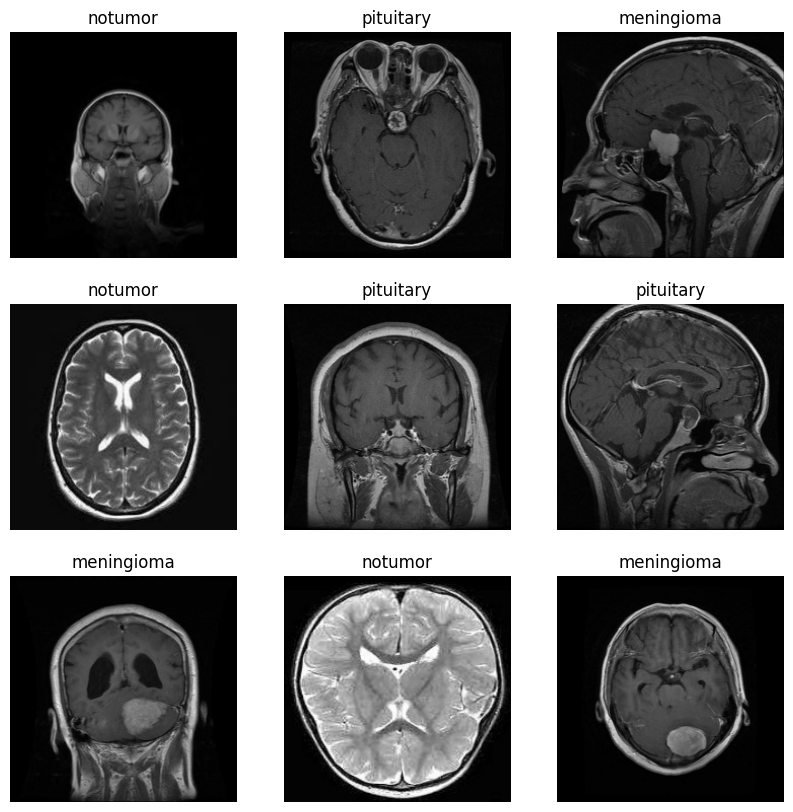

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


# 5. Model Building (Transfer Learning with EfficientNetB0)

In [8]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.8, patience=3)

history = model.fit(train_data,validation_data=test_data,epochs=10, callbacks=[early_stop, reduce_lr],verbose=1)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 235ms/step - accuracy: 0.7985 - loss: 0.5471 - val_accuracy: 0.9016 - val_loss: 0.2457 - learning_rate: 0.0010
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9270 - loss: 0.1925 - val_accuracy: 0.9184 - val_loss: 0.2153 - learning_rate: 0.0010
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9382 - loss: 0.1463 - val_accuracy: 0.9443 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9593 - loss: 0.1096 - val_accuracy: 0.9481 - val_loss: 0.1239 - learning_rate: 0.0010
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9658 - loss: 0.0951 - val_accuracy: 0.9580 - val_loss: 0.0968 - learning_rate: 0.0010
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9777 - loss: 0.0658 - val_accuracy: 0.9535 - val_loss: 0.1059 - learning_rate: 0.0010
Epoch 7/10
179/179 ━━━━━━

# 7. Plot Training Curves

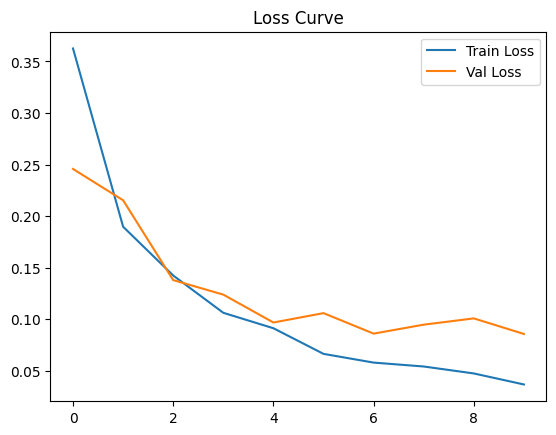

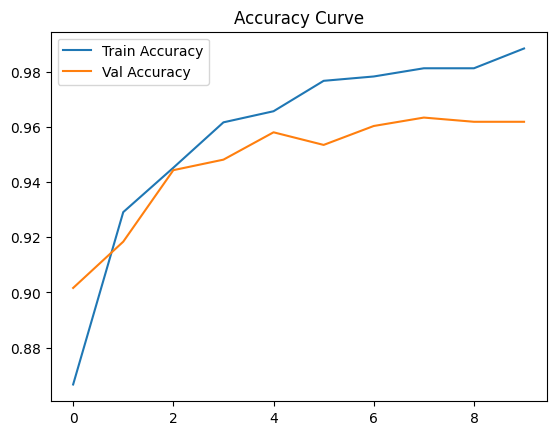

In [13]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

# 8. Evaluation & Classification Report

In [14]:
y_true, y_pred = [], []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━

# 9. Confusion Matrix

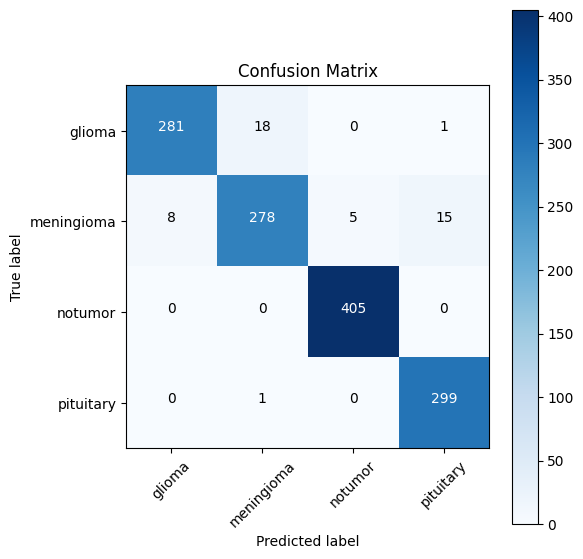

In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > cm.max()/2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# 10. ROC Curve (One-vs-Rest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━

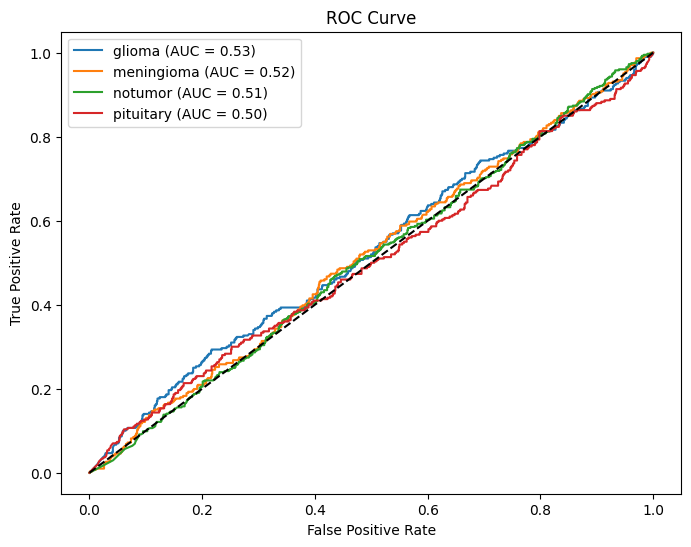

In [16]:
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
y_score = []

for images, _ in test_data:
    preds = model.predict(images)
    y_score.extend(preds)

y_score = np.array(y_score)

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# --- Save the trained model ---

In [17]:
model.save("mri_model.h5")
print(" Model saved successfully as 'mri_model.h5'")

 Model saved successfully as 'mri_model.h5'


# MRI Inferece Code

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# --- Load Trained Model ---
model = load_model("mri_model.h5")

# --- Define Class Names (same as training) ---
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# --- Unified Prediction Function ---
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_mri_image(img_path):
    # Load & preprocess image
    img = image.load_img(img_path, target_size=(224, 224), color_mode="rgb")
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Important for EfficientNet

    # Predict
    preds = model.predict(img_array)[0]
    predicted_idx = np.argmax(preds)
    predicted_class = class_names[predicted_idx]
    confidence = preds[predicted_idx] * 100

    # Display image with prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()

    # Display probability bar plot
    plt.figure(figsize=(6, 4))
    plt.bar(class_names, preds, color="skyblue")
    plt.title("Class Probabilities")
    plt.ylabel("Confidence")
    plt.ylim([0, 1])
    for i, p in enumerate(preds):
        plt.text(i, p + 0.01, f"{p*100:.1f}%", ha="center")
    plt.show()

    print(f"\nPredicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


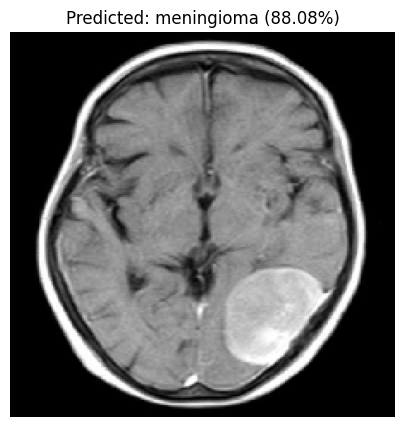

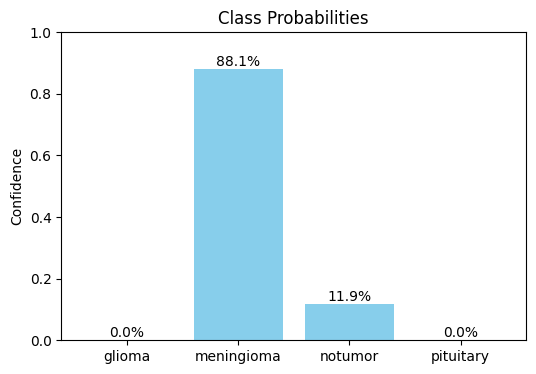


Predicted Class: meningioma
Confidence: 88.08%


In [23]:
# --- Example Usage ---
predict_mri_image("/content/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0004.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


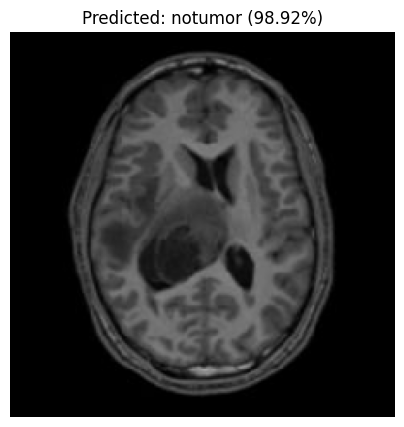

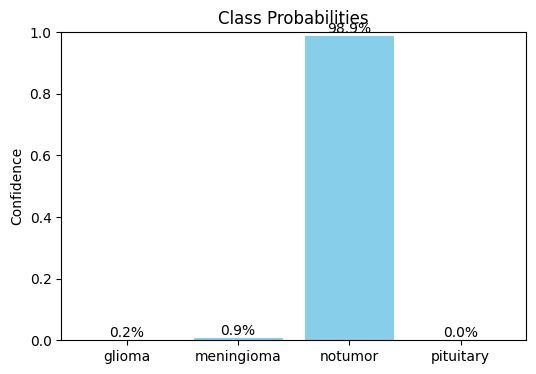


Predicted Class: notumor
Confidence: 98.92%


In [24]:
# --- Example Usage ---
predict_mri_image("/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_0065.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


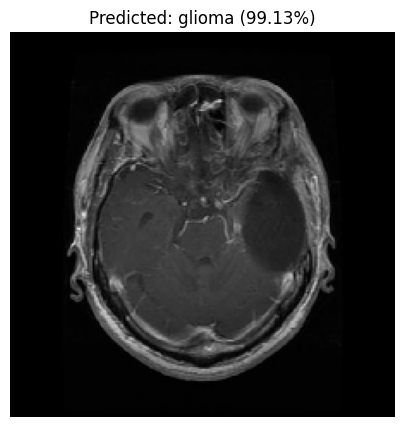

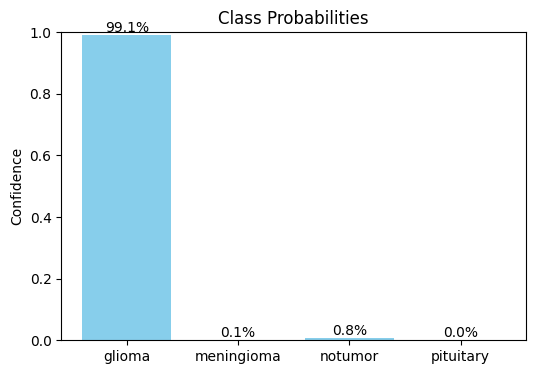


Predicted Class: glioma
Confidence: 99.13%


In [25]:
# --- Example Usage ---
predict_mri_image("/content/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0015.jpg")